# One HCPCS Code Grouped by State

In [ ]:
# Data frame created by subsecting the original data to include only female M.D.s working in a facility that participates in Medicare and practices Diagnostic Radiology, 
# The data was then subsected again using one HCPCS code and then grouped by state
# K means was executed on the mean request from medicare and payment recieved as well as the percent recieved (payment/request)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

#import seaborn as sns
#import gc

In [2]:
#Import data 
missing_values = ["n/a", "na", "--"]
medicaredf = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2017.txt",sep='	',na_values = missing_values)
print(medicaredf.head())

#Understanding basic info about data

medicaredf.columns #26 columns
medicaredf.shape #9,847,444 rows
medicaredf.info()
medicaredf.describe()
print(medicaredf.isnull().sum())
#remove outliers (amount requested from medicare should never be smaller than the amount recieved)
medicaredf["percentage"]=medicaredf['average_Medicare_payment_amt']/medicaredf['average_submitted_chrg_amt']
medicaredf=medicaredf[medicaredf["percentage"]<1]
print(medicaredf.head())

/Users/anna2/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


          npi                       nppes_provider_last_org_name  \
0           1  CPT copyright 2016 American Medical Associatio...   
1  1003000126                                          ENKESHAFI   
2  1003000126                                          ENKESHAFI   
3  1003000126                                          ENKESHAFI   
4  1003000126                                          ENKESHAFI   

  nppes_provider_first_name nppes_provider_mi nppes_credentials  \
0                       NaN               NaN               NaN   
1                   ARDALAN               NaN              M.D.   
2                   ARDALAN               NaN              M.D.   
3                   ARDALAN               NaN              M.D.   
4                   ARDALAN               NaN              M.D.   

  nppes_provider_gender nppes_entity_code nppes_provider_street1  \
0                   NaN               NaN                    NaN   
1                     M                 I           

In [18]:
## Create new dataframe of npi, state, Medicare amount requested, and amount paid (df)
df=medicaredf.iloc[: , [0, 4,5, 11,13, 14, 15,16,23, 24]].copy() 
df.columns= ["npi", "credentials","gender","state","caretype","participate", "facility","hcpcscode","request", "payment"]
#Remove rows where state is NaN because exploring how the state/ region affects the medicare payments and missing state will create unknown data points
df = df[pd.notnull(df["state"])]
print(df.head(15))
#Remove rows where payment/request>1 because this means they recieved more than they asked for which should not be the case and these will be outliers
df["percentage"]=df["payment"]/df["request"]
df=df[df["percentage"]<1]
print(df.head(15))

           npi credentials gender state           caretype participate  \
1   1003000126        M.D.      M    MD  Internal Medicine           Y   
2   1003000126        M.D.      M    MD  Internal Medicine           Y   
3   1003000126        M.D.      M    MD  Internal Medicine           Y   
4   1003000126        M.D.      M    MD  Internal Medicine           Y   
5   1003000126        M.D.      M    MD  Internal Medicine           Y   
6   1003000126        M.D.      M    MD  Internal Medicine           Y   
7   1003000126        M.D.      M    MD  Internal Medicine           Y   
8   1003000126        M.D.      M    MD  Internal Medicine           Y   
9   1003000126        M.D.      M    MD  Internal Medicine           Y   
10  1003000126        M.D.      M    MD  Internal Medicine           Y   
11  1003000126        M.D.      M    MD  Internal Medicine           Y   
12  1003000134        M.D.      M    IL          Pathology           Y   
13  1003000134        M.D.      M    I

In [82]:
x=df.credentials.unique()
print(x)
print(x.size)

['M.D.' 'D.O.' 'MD' ... 'MA,' 'L.AC, PA-C' 'RN MSN HSA FNP-C']
15986


In [19]:
df = df[df['credentials'].str.contains('M.D.', na=False)]
df = df[df['gender'].str.contains('F', na=False)]
df = df[df['participate'].str.contains('Y', na=False)]
df = df[df['facility'].str.contains('F', na=False)]
print(df)

                npi credentials gender state                 caretype  \
462      1003002627        M.D.      F    TX  Obstetrics & Gynecology   
587      1003002841        M.D.      F    SC                Neurology   
588      1003002841        M.D.      F    SC                Neurology   
589      1003002841        M.D.      F    SC                Neurology   
590      1003002841        M.D.      F    SC                Neurology   
...             ...         ...    ...   ...                      ...   
9847086  1992996375        M.D.      F    WI            Endocrinology   
9847314  1992998009        M.D.      F    FL               Psychiatry   
9847315  1992998009        M.D.      F    FL               Psychiatry   
9847316  1992998009        M.D.      F    FL               Psychiatry   
9847317  1992998009        M.D.      F    FL               Psychiatry   

        participate facility hcpcscode      request     payment  percentage  
462               Y        F     58558  1070.

In [13]:
print(df.caretype.unique())
df['caretype'].value_counts()

['Obstetrics & Gynecology' 'Neurology' 'Pulmonary Disease'
 'Internal Medicine' 'Anesthesiology' 'Ophthalmology'
 'Physical Medicine and Rehabilitation' 'Gastroenterology'
 'General Surgery' 'Psychiatry' 'Family Practice' 'Emergency Medicine'
 'Endocrinology' 'Diagnostic Radiology' 'Neurosurgery' 'Nephrology'
 'Radiation Oncology' 'Vascular Surgery' 'Otolaryngology'
 'Pediatric Medicine' 'Pathology' 'Rheumatology' 'Hospitalist'
 'Critical Care (Intensivists)' 'Infectious Disease' 'Hematology'
 'Geriatric Medicine' 'Cardiology' 'Cardiac Surgery' 'Hematology-Oncology'
 'Sports Medicine' 'Surgical Oncology' 'Urology'
 'Undefined Physician type' 'Medical Oncology'
 'Interventional Pain Management' 'Thoracic Surgery'
 'Interventional Cardiology' 'Orthopedic Surgery' 'Dermatology'
 'General Practice' 'Hospice and Palliative Care'
 'Interventional Radiology' 'Colorectal Surgery (Proctology)'
 'Hand Surgery' 'Plastic and Reconstructive Surgery' 'Pain Management'
 'Clinical Cardiac Electrophysi

Diagnostic Radiology        66652
Internal Medicine           45655
Pathology                   23582
Emergency Medicine          18755
Anesthesiology              16694
                            ...  
Clinic or Group Practice        7
Maxillofacial Surgery           7
Physician Assistant             4
Podiatry                        1
Anesthesiology Assistant        1
Name: caretype, Length: 66, dtype: int64

In [20]:
df = df[df['caretype'].str.contains('Diagnostic Radiology', na=False)]
print(df.head())

             npi credentials gender state              caretype participate  \
5087  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5089  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5090  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5091  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
5092  1003027533        M.D.      F    TX  Diagnostic Radiology           Y   

     facility hcpcscode     request     payment  percentage  
5087        F     19081  680.000000  128.848000    0.189482  
5089        F     70450  166.072165   32.053402    0.193009  
5090        F     71010   35.666667    7.109807    0.199340  
5091        F     71020   42.033333    7.623333    0.181364  
5092        F     71250  201.363636   40.196364    0.199621  


In [7]:
x=df.hcpcscode.unique()
print(x.size)
df["hcpcscode"].value_counts()

467


71010    1945
71020    1853
74177    1630
74000    1575
74176    1555
         ... 
72142       1
75716       1
78499       1
78070       1
78201       1
Name: hcpcscode, Length: 467, dtype: int64

In [21]:
df = df[df['hcpcscode'].str.contains('71010', na=False)]
print(df.head())

              npi credentials gender state              caretype participate  \
5090   1003027533        M.D.      F    TX  Diagnostic Radiology           Y   
15058  1003084971        M.D.      F    LA  Diagnostic Radiology           Y   
21362  1003136490        M.D.      F    TX  Diagnostic Radiology           Y   
24793  1003179284        M.D.      F    PA  Diagnostic Radiology           Y   
37186  1003807439        M.D.      F    TX  Diagnostic Radiology           Y   

      facility hcpcscode    request   payment  percentage  
5090         F     71010  35.666667  7.109807    0.199340  
15058        F     71010  24.085791  7.256273    0.301268  
21362        F     71010  35.489736  7.034194    0.198204  
24793        F     71010  42.000000  7.670000    0.182619  
37186        F     71010  36.000000  6.874436    0.190957  


In [22]:
df=df.drop(columns=["credentials", "gender","participate", "facility", "percentage","caretype","hcpcscode"])
df=df.reset_index(drop=True)
print(df)

             npi state    request   payment
0     1003027533    TX  35.666667  7.109807
1     1003084971    LA  24.085791  7.256273
2     1003136490    TX  35.489736  7.034194
3     1003179284    PA  42.000000  7.670000
4     1003807439    TX  36.000000  6.874436
...          ...   ...        ...       ...
1940  1992906556    TX  33.000000  7.350000
1941  1992930390    NY  35.000000  7.833200
1942  1992948749    NY  25.358621  7.929062
1943  1992954150    OH  26.000000  6.532131
1944  1992956494    IL  37.982036  7.512575

[1945 rows x 4 columns]


In [23]:
pd.get_dummies(df['state'],prefix='State')
#print(pd.get_dummies(medicaredf['nppes_provider_state'],prefix='State').head())
df = pd.concat([df,pd.get_dummies(df['state'])],axis=1)
print(df)
#Not dropping "state" because it is easier to compare categorically later
state=df['state']

             npi state    request   payment  AK  AL  AR  AZ  CA  CO  ...  SD  \
0     1003027533    TX  35.666667  7.109807   0   0   0   0   0   0  ...   0   
1     1003084971    LA  24.085791  7.256273   0   0   0   0   0   0  ...   0   
2     1003136490    TX  35.489736  7.034194   0   0   0   0   0   0  ...   0   
3     1003179284    PA  42.000000  7.670000   0   0   0   0   0   0  ...   0   
4     1003807439    TX  36.000000  6.874436   0   0   0   0   0   0  ...   0   
...          ...   ...        ...       ...  ..  ..  ..  ..  ..  ..  ...  ..   
1940  1992906556    TX  33.000000  7.350000   0   0   0   0   0   0  ...   0   
1941  1992930390    NY  35.000000  7.833200   0   0   0   0   0   0  ...   0   
1942  1992948749    NY  25.358621  7.929062   0   0   0   0   0   0  ...   0   
1943  1992954150    OH  26.000000  6.532131   0   0   0   0   0   0  ...   0   
1944  1992956494    IL  37.982036  7.512575   0   0   0   0   0   0  ...   0   

      TN  TX  UT  VA  VT  WA  WI  WV  W

In [24]:
#Removing non-US states - Commented out rows are due to previous subsections
#df = df[df.XX != 1]
#df = df[df.AA != 1]
#df = df[df.AP != 1]
#df = df[df.AS != 1]
df = df[df.GU != 1]
#df = df[df.MP != 1]
df = df[df.PR != 1]
#df = df[df.VI != 1]
#df = df[df.ZZ != 1]
df = df[df.DC != 1]

In [25]:
df=df.drop(columns=['DC','GU','PR'])
df=df.reset_index(drop=True)
df=df.drop(df.columns[0], axis = 1) 
df=df.drop(df.columns[3:55], axis = 1) 
print(df)

     state    request   payment
0       TX  35.666667  7.109807
1       LA  24.085791  7.256273
2       TX  35.489736  7.034194
3       PA  42.000000  7.670000
4       TX  36.000000  6.874436
...    ...        ...       ...
1917    TX  33.000000  7.350000
1918    NY  35.000000  7.833200
1919    NY  25.358621  7.929062
1920    OH  26.000000  6.532131
1921    IL  37.982036  7.512575

[1922 rows x 3 columns]


In [26]:
df = df.groupby("state")["request","payment"].mean()

(array([3., 1., 5., 5., 9., 8., 6., 8., 2., 3.]),
 array([0.12566531, 0.13854372, 0.15142213, 0.16430054, 0.17717894,
        0.19005735, 0.20293576, 0.21581417, 0.22869257, 0.24157098,
        0.25444939]),
 <a list of 10 Patch objects>)

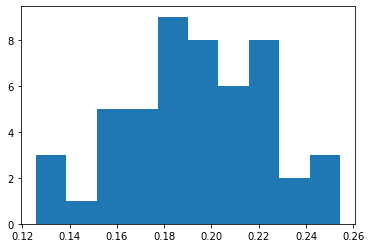

In [27]:
df["percentage"]=df["payment"]/df["request"]
plt.hist(df['percentage'])

In [28]:
scaler = preprocessing.StandardScaler().fit(df)
dfNorm = scaler.transform(df)

In [14]:
maxClusters = 50
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [15]:
print(sse)

[80.64294847097239, 58.5673854738003, 42.63219615406334, 29.352048403262547, 22.657897037343993, 18.281164375513303, 14.704710300102136, 12.676157400954317, 10.685435128548356, 8.907883952195299, 8.166137653308729, 6.784331889830273, 6.371416115655333, 5.596941205797252, 4.721304671705224, 4.087904344944657, 3.5750033466854925, 3.0562830364162004, 2.809050241208717, 2.43144068390972, 2.1850027962568475, 1.9232973920514074, 1.5985022227308487, 1.3879759062982222, 1.2147297582085927, 1.11372748465745, 0.9532960327017235, 0.8357913251343172, 0.7237084764236202, 0.5858450546513021, 0.5240077799294452, 0.4599474560530837, 0.4216459393050353, 0.36710495973124047, 0.3264474091638989, 0.28516722985374465, 0.24686571310569627, 0.21593731393461477, 0.1862550808328255, 0.15748241010424247, 0.12969094319169538, 0.10325723957945973, 0.0793999650761176, 0.057872201168086244, 0.041559836311559004, 0.029395312343313097, 0.018936155201706634, 0.008699727907402144]


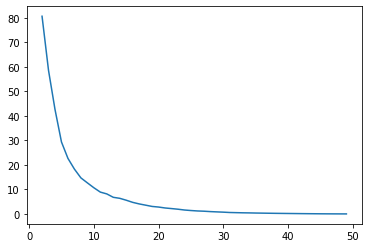

In [64]:
plt.plot(range(2,maxClusters),sse)

In [65]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_)
    silh.append(silhouette_avg)
print(silh)

[0.39240100258293803, 0.4157900875490344, 0.37655778534676093, 0.3843036917798925, 0.3846673038728088, 0.34908695343547536, 0.3723168260996377, 0.376228908541308, 0.3711341728643756, 0.37463568171071904, 0.34638260073188426, 0.3708901016229937, 0.3583700473856218, 0.35158065804927235, 0.396246468209991, 0.41593104536710357, 0.38949903210884307, 0.3785862711655069, 0.3839138559153, 0.3504592369864883, 0.34929214121194635, 0.3642326569641593, 0.37998444590789476, 0.3698536479593335, 0.3645796645261777, 0.3368029218906271, 0.34466489830374186, 0.3263796055540644, 0.3072141201969911, 0.31469641826370914, 0.3051582242330019, 0.29264661831704386, 0.26964627794348106, 0.25969351122567175, 0.2423000792667117, 0.22511378871941645, 0.20833292545011364, 0.1913734953471696, 0.1859095205831586, 0.17277553040000018, 0.14998460303619215, 0.12866719089956624, 0.12163354701219148, 0.09928154664104642, 0.07863163098684506, 0.05455793635972459, 0.04449808810698589, 0.032212446374188415]


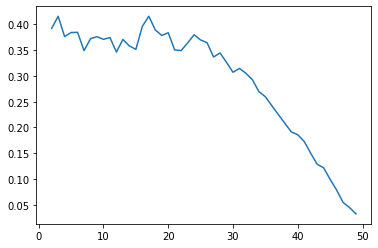

In [29]:
plt.plot(range(2,maxClusters),silh)

In [29]:
#K-Means Clustering
kmeans = KMeans(n_clusters=6, random_state=0).fit(dfNorm)


In [30]:
df=df.reset_index(drop=False)
clusters = pd.concat([df,pd.DataFrame(kmeans.labels_,columns=["Cluster"])],axis=1)

In [31]:
print(clusters)

   state    request   payment  percentage  Cluster
0     AK  48.333188  8.684360    0.179677        4
1     AL  33.711209  6.756634    0.200427        5
2     AR  29.349463  6.462637    0.220196        5
3     AZ  33.739988  6.928650    0.205354        5
4     CA  44.104725  7.220955    0.163723        3
5     CO  32.937273  6.974334    0.211746        5
6     CT  38.626864  7.428870    0.192324        1
7     DE  33.368627  7.467675    0.223793        1
8     FL  37.982258  7.085829    0.186556        1
9     GA  41.219655  6.991734    0.169621        3
10    HI  37.086735  6.794389    0.183203        3
11    IA  36.733575  6.715730    0.182823        3
12    ID  27.580000  6.206557    0.225038        5
13    IL  44.024068  7.266730    0.165063        3
14    IN  31.768056  6.755977    0.212666        5
15    KS  30.327164  6.646264    0.219152        5
16    KY  31.347033  6.787626    0.216532        5
17    LA  30.195555  7.046652    0.233367        0
18    MA  35.647107  7.348998  

In [32]:
clusters=clusters.sort_values('Cluster')

In [33]:
pd.set_option('display.max_rows', None)
display(clusters)

,state,request,payment,percentage,Cluster
27,ND,29.000000,7.379032,0.254449,0
23,MO,29.891431,6.907422,0.231084,0
21,MI,30.940590,6.955523,0.224803,0
43,UT,28.322543,6.859645,0.242197,0
17,LA,30.195555,7.046652,0.233367,0
40,SD,27.646785,6.794326,0.245755,0
19,MD,37.060233,7.385015,0.199271,1
18,MA,35.647107,7.348998,0.206160,1
33,NY,38.523835,7.563463,0.196332,1
37,PA,37.920809,7.185849,0.189496,1


In [34]:
clusters.groupby('Cluster').mean()

,request,payment,percentage
Cluster,,,
0,29.332817,6.990433,0.238609
1,37.131949,7.334442,0.198087
2,51.261256,7.116773,0.139352
3,40.454630,6.905439,0.171414
4,48.333188,8.684360,0.179677
5,32.060014,6.700000,0.209482


In [35]:
clusters['Cluster'].value_counts()

5    15
3    14
1     9
0     6
2     5
4     1
Name: Cluster, dtype: int64

In [36]:
clusters.describe()

,request,payment,percentage,Cluster
count,50.000000,50.000000,50.000000,50.000000
mean,37.241779,6.987939,0.192658,2.800000
std,6.822848,0.375347,0.029668,1.772811
min,27.580000,6.206557,0.125665,0.000000
25%,31.889696,6.775557,0.172473,1.000000
50%,36.725878,6.941396,0.194867,3.000000
75%,40.836777,7.160844,0.215565,5.000000
max,55.906690,8.684360,0.254449,5.000000


In [37]:
export_csv = clusters.to_csv (r'C:\Users\anna2\Desktop\IEMS 308\onehcpcs.csv', index = None, header=True)